In [1]:
import gc
import glob
import os
import json
import matplotlib.pyplot as plt
import pprint

import numpy as np
import pandas as pd

from joblib import Parallel, delayed
from tqdm import tqdm
from PIL import Image

%matplotlib inline

pd.options.display.max_rows = 128
pd.options.display.max_columns = 128

In [55]:
train = pd.read_csv('C:/Users/divya/Downloads/PetFinder/train/train.csv')
test  = pd.read_csv('C:/Users/divya/Downloads/PetFinder/test/test.csv')
sample_submission = pd.read_csv('C:/Users/divya/Downloads/PetFinder/test/sample_submission.csv')
labels_breed = pd.read_csv('C:/Users/divya/Downloads/PetFinder/breed_labels.csv')
labels_color= pd.read_csv('C:/Users/divya/Downloads/PetFinder/color_labels.csv')
labels_state = pd.read_csv('C:/Users/divya/Downloads/PetFinder/state_labels.csv')

In [56]:
train_feats = pd.read_csv("C:/Users/divya/Downloads/PetFinder/train_img_features.csv")
test_feats = pd.read_csv("C:/Users/divya/Downloads/PetFinder/test_img_features.csv")

train_feats.rename({'Unnamed: 0': 'PetID'}, axis='columns', inplace=True)
test_feats.rename({'Unnamed: 0': 'PetID'}, axis='columns', inplace=True)

train_feats = train_feats.set_index('PetID')
test_feats = test_feats.set_index('PetID')

train_feats.columns = [f'pic_{i}' for i in range(train_feats.shape[1])]
test_feats.columns = [f'pic_{i}' for i in range(test_feats.shape[1])]

all_ids = pd.concat([train, test], axis=0, ignore_index=True, sort=False)[['PetID']]
all_ids.shape

(18941, 1)

In [4]:
from sklearn.decomposition import SparsePCA, TruncatedSVD, LatentDirichletAllocation, NMF

n_components = 32
svd_ = TruncatedSVD(n_components=n_components, random_state=1337)

features_df = pd.concat([train_feats, test_feats], axis=0)
features = features_df[[f'pic_{i}' for i in range(256)]].values

svd_col = svd_.fit_transform(features)
svd_col = pd.DataFrame(svd_col)
svd_col = svd_col.add_prefix('IMG_SVD_')

img_features = pd.concat([all_ids, svd_col], axis=1)

In [57]:
doc_sent_mag = []
doc_sent_score = []
mag = []
score = []
ent = []
nf_count = 0
for pet in train.PetID.values:
    try:
        with open('C:/Users/divya/Downloads/PetFinder/train_sentiment/' + pet + '.json', 'r',encoding="utf8") as f:
            sentiment = json.load(f)
        doc_sent_mag.append(sentiment['documentSentiment']['magnitude'])
        doc_sent_score.append(sentiment['documentSentiment']['score'])
        
        entities = ([x['name'] for x in sentiment['entities']])
        sentence_sep = ' '
        file_entities = sentence_sep.join(entities)
        ent.append(file_entities)
        
        sent_data = [x['sentiment'] for x in sentiment['sentences']]
        sent_data = pd.DataFrame.from_dict(sent_data, orient='columns').sum()
        mag.append(sent_data['magnitude'])
        score.append(sent_data['score'])
    except FileNotFoundError:
        nf_count += 1
        doc_sent_mag.append(-1)
        doc_sent_score.append(-1)
        ent.append('None')
        mag.append(-1)
        score.append(-1)

In [58]:
df_sentiment = pd.DataFrame(doc_sent_mag,columns={'doc_sent_mag'})
df_sentiment['doc_sent_score'] = doc_sent_score
df_sentiment['entities'] = ent
df_sentiment['sentiment_magnitude'] = mag
df_sentiment['sentiment_score'] = score
df_sentiment['PetID'] = train.PetID
df_sentiment.shape

(14993, 6)

In [59]:
aggregates = ['mean', 'sum', 'var']
train_sentiment_desc = df_sentiment.groupby(['PetID'])['entities'].unique()
train_sentiment_desc = train_sentiment_desc.reset_index()
train_sentiment_desc['entities'] = train_sentiment_desc['entities'].apply(lambda x: ' '.join(x))
train_sentiment_gr = df_sentiment.drop(['entities'], axis=1)
for i in train_sentiment_gr.columns:
    if 'PetID' not in i:
        train_sentiment_gr[i] = train_sentiment_gr[i].astype(float)
train_sentiment_gr = train_sentiment_gr.groupby(['PetID']).agg(aggregates) 
train_sentiment_gr.columns = pd.Index(['{}_{}'.format(c[0], c[1].upper()) for c in train_sentiment_gr.columns.tolist()])
train_sentiment_gr = train_sentiment_gr.reset_index()

In [60]:
train_proc = train.copy()
train_proc = train_proc.merge(train_sentiment_gr, how='left', on='PetID')
train_proc = train_proc.merge(train_sentiment_desc, how='left', on='PetID')

In [61]:
doc_sent_mag = []
doc_sent_score = []
mag = []
score = []
ent = []
nf_count = 0
for pet in test.PetID.values:
    try:
        with open('C:/Users/divya/Downloads/PetFinder/test_sentiment/' + pet + '.json', 'r',encoding="utf8") as f:
            sentiment = json.load(f)
        doc_sent_mag.append(sentiment['documentSentiment']['magnitude'])
        doc_sent_score.append(sentiment['documentSentiment']['score'])
        
        entities = ([x['name'] for x in sentiment['entities']])
        sentence_sep = ' '
        file_entities = sentence_sep.join(entities)
        ent.append(file_entities)
        
        sent_data = [x['sentiment'] for x in sentiment['sentences']]
        sent_data = pd.DataFrame.from_dict(sent_data, orient='columns').sum()
        mag.append(sent_data['magnitude'])
        score.append(sent_data['score'])
    except FileNotFoundError:
        nf_count += 1
        doc_sent_mag.append(-1)
        doc_sent_score.append(-1)
        ent.append('None')
        mag.append(-1)
        score.append(-1)

In [62]:
df_sentiment = pd.DataFrame(doc_sent_mag,columns={'doc_sent_mag'})
df_sentiment['doc_sent_score'] = doc_sent_score
df_sentiment['entities'] = ent
df_sentiment['sentiment_magnitude'] = mag
df_sentiment['sentiment_score'] = score
df_sentiment['PetID'] = test.PetID
df_sentiment.shape

(3948, 6)

In [63]:
#aggregates = ['mean', 'sum', 'avg']
test_sentiment_desc = df_sentiment.groupby(['PetID'])['entities'].unique()
test_sentiment_desc = test_sentiment_desc.reset_index()
test_sentiment_desc['entities'] = test_sentiment_desc['entities'].apply(lambda x: ' '.join(x))
test_sentiment_gr = df_sentiment.drop(['entities'], axis=1)
for i in test_sentiment_gr.columns:
    if 'PetID' not in i:
        test_sentiment_gr[i] = test_sentiment_gr[i].astype(float)
test_sentiment_gr = test_sentiment_gr.groupby(['PetID']).agg(aggregates)      
test_sentiment_gr.columns = pd.Index(['{}_{}'.format(c[0], c[1].upper()) for c in test_sentiment_gr.columns.tolist()])
test_sentiment_gr = test_sentiment_gr.reset_index()

In [64]:
test_proc = test.copy()
test_proc = test_proc.merge(test_sentiment_gr, how='left', on='PetID')
test_proc = test_proc.merge(test_sentiment_desc, how='left', on='PetID')

In [65]:
print(train.shape)
print(train_proc.shape)
print(test.shape)
print(test_proc.shape)

(14993, 24)
(14993, 37)
(3948, 23)
(3948, 36)


In [66]:
vertex_xs = []
vertex_ys = []
bounding_confidences = []
bounding_importance_fracs = []
dominant_blues = []
dominant_greens = []
dominant_reds = []
dominant_pixel_fracs = []
dominant_scores = []
label_descriptions = []
label_scores = []
nf_count = 0
nl_count = 0
for pet in train.PetID.values:
    try:
        #with open('../input/train_metadata/' + pet + '-1.json', 'r') as f:
        with open('C:/Users/divya/Downloads/PetFinder/train_metadata/' + pet + '-1.json', 'r',encoding="utf8") as f:
            data = json.load(f)
            vertex_x = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['x']
            vertex_xs.append(vertex_x)
            vertex_y = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['y']
            vertex_ys.append(vertex_y)
            bounding_confidence = data['cropHintsAnnotation']['cropHints'][0]['confidence']
            bounding_confidences.append(bounding_confidence)
            bounding_importance_frac = data['cropHintsAnnotation']['cropHints'][0].get('importanceFraction', -1)
            bounding_importance_fracs.append(bounding_importance_frac)
            dominant_blue = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['blue']
            dominant_blues.append(dominant_blue)
            dominant_green = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['green']
            dominant_greens.append(dominant_green)
            dominant_red = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['red']
            dominant_reds.append(dominant_red)
            dominant_pixel_frac = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['pixelFraction']
            dominant_pixel_fracs.append(dominant_pixel_frac)
            dominant_score = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['score']
            dominant_scores.append(dominant_score)
            if data.get('labelAnnotations'):
                label_description = data['labelAnnotations'][0]['description']
                label_descriptions.append(label_description)
                label_score = data['labelAnnotations'][0]['score']
                label_scores.append(label_score)
            else:
                nl_count += 1
                label_descriptions.append('nothing')
                label_scores.append(-1)
    except FileNotFoundError:
        nf_count += 1
        vertex_xs.append(-1)
        vertex_ys.append(-1)
        bounding_confidences.append(-1)
        bounding_importance_fracs.append(-1)
        dominant_blues.append(-1)
        dominant_greens.append(-1)
        dominant_reds.append(-1)
        dominant_pixel_fracs.append(-1)
        dominant_scores.append(-1)
        label_descriptions.append('nothing')
        label_scores.append(-1)

In [67]:
df_metadata = pd.DataFrame(vertex_xs,columns={'vertex_x'})
df_metadata['vertex_y'] = vertex_ys
df_metadata['bounding_confidence'] = bounding_confidences
df_metadata['bounding_importance'] = bounding_importance_fracs
df_metadata['dominant_blue'] = dominant_blues
df_metadata['dominant_green'] = dominant_greens
df_metadata['dominant_red'] = dominant_reds
df_metadata['dominant_pixel_frac'] = dominant_pixel_fracs
df_metadata['dominant_score'] = dominant_scores
df_metadata['label_description'] = label_descriptions
df_metadata['label_score'] = label_scores
df_metadata['PetID'] = train.PetID
df_metadata.shape

(14993, 12)

In [68]:
#aggregates = ['mean', 'sum']
train_metadata_desc = df_metadata.groupby(['PetID'])['label_description'].unique()
train_metadata_desc = train_metadata_desc.reset_index()
train_metadata_desc['label_description'] = train_metadata_desc['label_description'].apply(lambda x : ''.join(x))
train_metadata_gr = df_metadata.drop(['label_description'], axis=1)
for i in train_metadata_gr.columns:
    if 'PetID' not in i:
        train_metadata_gr[i] = train_metadata_gr[i].astype(float)
train_metadata_gr = train_metadata_gr.groupby(['PetID']).agg(aggregates)
train_metadata_gr.columns = pd.Index(['{}_{}'.format(c[0], c[1].upper()) for c in train_metadata_gr.columns.tolist()])
train_metadata_gr = train_metadata_gr.reset_index()

In [69]:
train_proc = train_proc.merge(train_metadata_gr, how='left', on='PetID')
train_proc = train_proc.merge(train_metadata_desc, how='left', on='PetID')

In [70]:
vertex_xs = []
vertex_ys = []
bounding_confidences = []
bounding_importance_fracs = []
dominant_blues = []
dominant_greens = []
dominant_reds = []
dominant_pixel_fracs = []
dominant_scores = []
label_descriptions = []
label_scores = []
nf_count = 0
nl_count = 0
for pet in test.PetID.values:
    try:
        #with open('../input/test_metadata/' + pet + '-1.json', 'r') as f:
        with open('C:/Users/divya/Downloads/PetFinder/test_metadata/' + pet + '-1.json', 'r',encoding="utf8") as f:
            data = json.load(f)
            vertex_x = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['x']
            vertex_xs.append(vertex_x)
            vertex_y = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['y']
            vertex_ys.append(vertex_y)
            bounding_confidence = data['cropHintsAnnotation']['cropHints'][0]['confidence']
            bounding_confidences.append(bounding_confidence)
            bounding_importance_frac = data['cropHintsAnnotation']['cropHints'][0].get('importanceFraction', -1)
            bounding_importance_fracs.append(bounding_importance_frac)
            dominant_blue = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['blue']
            dominant_blues.append(dominant_blue)
            dominant_green = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['green']
            dominant_greens.append(dominant_green)
            dominant_red = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['red']
            dominant_reds.append(dominant_red)
            dominant_pixel_frac = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['pixelFraction']
            dominant_pixel_fracs.append(dominant_pixel_frac)
            dominant_score = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['score']
            dominant_scores.append(dominant_score)
            if data.get('labelAnnotations'):
                label_description = data['labelAnnotations'][0]['description']
                label_descriptions.append(label_description)
                label_score = data['labelAnnotations'][0]['score']
                label_scores.append(label_score)
            else:
                nl_count += 1
                label_descriptions.append('nothing')
                label_scores.append(-1)
    except FileNotFoundError:
        nf_count += 1
        vertex_xs.append(-1)
        vertex_ys.append(-1)
        bounding_confidences.append(-1)
        bounding_importance_fracs.append(-1)
        dominant_blues.append(-1)
        dominant_greens.append(-1)
        dominant_reds.append(-1)
        dominant_pixel_fracs.append(-1)
        dominant_scores.append(-1)
        label_descriptions.append('nothing')
        label_scores.append(-1)

In [71]:
df_metadata = pd.DataFrame(vertex_xs,columns={'vertex_x'})
df_metadata['vertex_y'] = vertex_ys
df_metadata['bounding_confidence'] = bounding_confidences
df_metadata['bounding_importance'] = bounding_importance_fracs
df_metadata['dominant_blue'] = dominant_blues
df_metadata['dominant_green'] = dominant_greens
df_metadata['dominant_red'] = dominant_reds
df_metadata['dominant_pixel_frac'] = dominant_pixel_fracs
df_metadata['dominant_score'] = dominant_scores
df_metadata['label_description'] = label_descriptions
df_metadata['label_score'] = label_scores
df_metadata['PetID'] = test.PetID
df_metadata.shape

(3948, 12)

In [72]:
#aggregates = ['mean', 'sum', 'var']
test_metadata_desc = df_metadata.groupby(['PetID'])['label_description'].unique()
test_metadata_desc = test_metadata_desc.reset_index()
test_metadata_desc['label_description'] = test_metadata_desc['label_description'].apply(lambda x : ''.join(x))
test_metadata_gr = df_metadata.drop(['label_description'], axis=1)
for i in test_metadata_gr.columns:
    if 'PetID' not in i:
        test_metadata_gr[i] = test_metadata_gr[i].astype(float)
test_metadata_gr = test_metadata_gr.groupby(['PetID']).agg(aggregates)
test_metadata_gr.columns = pd.Index(['{}_{}'.format(c[0], c[1].upper()) for c in test_metadata_gr.columns.tolist()])
test_metadata_gr = test_metadata_gr.reset_index()

In [73]:
test_proc = test_proc.merge(test_metadata_gr, how='left', on='PetID')
test_proc = test_proc.merge(test_metadata_desc, how='left', on='PetID')

In [74]:
train_breed_main = train_proc[['Breed1']].merge(labels_breed, how='left', left_on='Breed1', right_on='BreedID',suffixes=('', '_main_breed')    )
train_breed_main = train_breed_main.iloc[:, 2:]
train_breed_main = train_breed_main.add_prefix('main_breed_')

train_breed_second = train_proc[['Breed2']].merge(labels_breed, how='left', left_on='Breed2', right_on='BreedID',suffixes=('', '_second_breed'))

train_breed_second = train_breed_second.iloc[:, 2:]
train_breed_second = train_breed_second.add_prefix('second_breed_')

train_proc = pd.concat([train_proc, train_breed_main, train_breed_second], axis=1)

In [75]:
test_breed_main = test_proc[['Breed1']].merge(labels_breed, how='left', left_on='Breed1', right_on='BreedID',suffixes=('', '_main_breed')    )
test_breed_main = test_breed_main.iloc[:, 2:]
test_breed_main = test_breed_main.add_prefix('main_breed_')

test_breed_second = test_proc[['Breed2']].merge(labels_breed, how='left', left_on='Breed2', right_on='BreedID',suffixes=('', '_second_breed'))

test_breed_second = test_breed_second.iloc[:, 2:]
test_breed_second = test_breed_second.add_prefix('second_breed_')

test_proc = pd.concat([test_proc, test_breed_main, test_breed_second], axis=1)

In [76]:
dtrain = train_proc.copy()
dtest = test_proc.copy()

In [77]:
with open('C:/Users/divya/Downloads/PetFinder/rating.json', 'r',encoding="utf8") as f:
    data = json.load(f)
species_keys = list(data.keys())    

# Spread species dictionary into a single dictionary.
breed_ratings_dict = {**data['cat_breeds']}
breed_ratings_dict = {**breed_ratings_dict,**data['dog_breeds']}

# Convert into a dataframe, transpose the table so the Breed is the index, rename the index.
breed_score_df = pd.DataFrame(breed_ratings_dict).T.reset_index().rename(columns={'index':'BreedName'})
train_proc = train_proc.merge(breed_score_df,how='left',left_on='main_breed_BreedName',right_on='BreedName')
test_proc = test_proc.merge(breed_score_df,how='left',left_on='main_breed_BreedName',right_on='BreedName')

In [78]:
print(train.shape)
print(train_proc.shape)
print(test.shape)
print(test_proc.shape)

(14993, 24)
(14993, 110)
(3948, 23)
(3948, 109)


In [79]:
X = pd.concat([train_proc, test_proc], ignore_index=True, sort=False)
print('NaN structure:\n{}'.format(np.sum(pd.isnull(X))))

NaN structure:
Type                                   0
Name                                1560
Age                                    0
Breed1                                 0
Breed2                                 0
Gender                                 0
Color1                                 0
Color2                                 0
Color3                                 0
MaturitySize                           0
FurLength                              0
Vaccinated                             0
Dewormed                               0
Sterilized                             0
Health                                 0
Quantity                               0
Fee                                    0
State                                  0
RescuerID                              0
VideoAmt                               0
Description                           14
PetID                                  0
PhotoAmt                               0
AdoptionSpeed                       3948
d

In [80]:
column_types = X.dtypes
int_cols = column_types[column_types == 'int64']
float_cols = column_types[column_types == 'float']
cat_cols = column_types[column_types == 'object']

In [81]:
# Copy original X DF for easier experimentation,
# all feature engineering will be performed on this one:
X_temp = X.copy()


# Select subsets of columns:
text_columns = ['Description', 'entities', 'label_description']
categorical_columns = ['main_breed_BreedName', 'second_breed_BreedName']

# Names are all unique, so they can be dropped by default
# Same goes for PetID, it shouldn't be used as a feature
to_drop_columns = ['PetID', 'Name', 'RescuerID','BreedName']
# RescuerID will also be dropped, as a feature based on this column will be extracted independently

In [82]:
# Count RescuerID occurrences:
rescuer_count = X.groupby(['RescuerID'])['PetID'].count().reset_index()
rescuer_count.columns = ['RescuerID', 'RescuerID_COUNT']

# Merge as another feature onto main DF:
X_temp = X_temp.merge(rescuer_count, how='left', on='RescuerID')

In [83]:
# Factorize categorical columns:
for i in categorical_columns:
    X_temp.loc[:, i] = pd.factorize(X_temp.loc[:, i])[0]

In [84]:
# Subset text features:
X_text = X_temp[text_columns]

for i in X_text.columns:
    X_text.loc[:, i] = X_text.loc[:, i].fillna('<MISSING>')

C:\Users\divya\Anaconda3\lib\site-packages\pandas\core\indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [85]:
np.sum(X_text.isnull())

Description          0
entities             0
label_description    0
dtype: int64

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import SparsePCA, TruncatedSVD, LatentDirichletAllocation, NMF

n_components = 10
text_features = []

# Generate text features:
for i in X_text.columns:
    # Initialize decomposition methods:
    print('generating features from: {}'.format(i))
    svd_ = TruncatedSVD(n_components=n_components, random_state=1337)
    nmf_ = NMF(n_components=n_components, random_state=1337)
    
    tfidf_col = TfidfVectorizer().fit_transform(X_text.loc[:, i].values)
    svd_col = svd_.fit_transform(tfidf_col)
    svd_col = pd.DataFrame(svd_col)
    svd_col = svd_col.add_prefix('SVD_{}_'.format(i))
    
    nmf_col = nmf_.fit_transform(tfidf_col)
    nmf_col = pd.DataFrame(nmf_col)
    nmf_col = nmf_col.add_prefix('NMF_{}_'.format(i))
    
    text_features.append(svd_col)
    text_features.append(nmf_col)

generating features from: Description
generating features from: entities
generating features from: label_description


In [87]:
# Combine all extracted features:
text_features = pd.concat(text_features, axis=1)

# Concatenate with main DF:
X_temp = pd.concat([X_temp, text_features], axis=1)

# Remove raw text columns:
for i in X_text.columns:
    X_temp = X_temp.drop(i, axis=1)

In [36]:
X_temp = X_temp.merge(img_features, how='left', on='PetID')

In [37]:
def getSize(filename):
    st = os.stat(filename)
    return st.st_size

def getDimensions(filename):
    img_size = Image.open(filename).size
    return img_size 

In [38]:
split_char = '/'

from PIL import Image
train_df_ids = train[['PetID']]
test_df_ids = test[['PetID']]

train_image_files = sorted(glob.glob('C:/Users/divya/Downloads/PetFinder/train_images/*.jpg'))
train_df_imgs = pd.DataFrame(train_image_files)
train_df_imgs.columns = ['image_filename']
train_imgs_pets = train_df_imgs['image_filename'].apply(lambda x: x.split(split_char)[-1].split('-')[0])
train_imgs_pets = train_imgs_pets.str.slice(start=13)

In [39]:
test_image_files = sorted(glob.glob('C:/Users/divya/Downloads/PetFinder/test_images/*.jpg'))
test_df_imgs = pd.DataFrame(test_image_files)
test_df_imgs.columns = ['image_filename']
test_imgs_pets = test_df_imgs['image_filename'].apply(lambda x: x.split(split_char)[-1].split('-')[0])
test_imgs_pets = test_imgs_pets.str.slice(start=12)

train_df_imgs = train_df_imgs.assign(PetID=train_imgs_pets)
test_df_imgs = test_df_imgs.assign(PetID=test_imgs_pets)

In [40]:
train_df_imgs['image_size'] = train_df_imgs['image_filename'].apply(getSize)
train_df_imgs['temp_size'] = train_df_imgs['image_filename'].apply(getDimensions)
train_df_imgs['width'] = train_df_imgs['temp_size'].apply(lambda x : x[0])
train_df_imgs['height'] = train_df_imgs['temp_size'].apply(lambda x : x[1])
train_df_imgs = train_df_imgs.drop(['temp_size'], axis=1)

test_df_imgs['image_size'] = test_df_imgs['image_filename'].apply(getSize)
test_df_imgs['temp_size'] = test_df_imgs['image_filename'].apply(getDimensions)
test_df_imgs['width'] = test_df_imgs['temp_size'].apply(lambda x : x[0])
test_df_imgs['height'] = test_df_imgs['temp_size'].apply(lambda x : x[1])
test_df_imgs = test_df_imgs.drop(['temp_size'], axis=1)

In [41]:
aggs = {
    'image_size': ['sum', 'mean', 'var'],
    'width': ['sum', 'mean', 'var'],
    'height': ['sum', 'mean', 'var'],
}

agg_train_imgs = train_df_imgs.groupby('PetID').agg(aggs)
new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
agg_train_imgs.columns = new_columns
agg_train_imgs = agg_train_imgs.reset_index()

agg_test_imgs = test_df_imgs.groupby('PetID').agg(aggs)
new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
agg_test_imgs.columns = new_columns
agg_test_imgs = agg_test_imgs.reset_index()

agg_imgs = pd.concat([agg_train_imgs, agg_test_imgs], axis=0).reset_index(drop=True)

In [42]:
X_temp = X_temp.merge(agg_imgs, how='left', on='PetID')

In [43]:
# Remove unnecessary columns:
X_temp = X_temp.drop(to_drop_columns, axis=1)

# Check final df shape:
print('X shape: {}'.format(X_temp.shape))

X shape: (18941, 205)


In [44]:
# Split into train and test again:
X_train = X_temp.loc[np.isfinite(X_temp.AdoptionSpeed), :]
X_test = X_temp.loc[~np.isfinite(X_temp.AdoptionSpeed), :]

# Remove missing target column from test:
X_test = X_test.drop(['AdoptionSpeed'], axis=1)


print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))

assert X_train.shape[0] == train.shape[0]
assert X_test.shape[0] == test.shape[0]


# Check if columns between the two DFs are the same:
train_cols = X_train.columns.tolist()
train_cols.remove('AdoptionSpeed')

test_cols = X_test.columns.tolist()

assert np.all(train_cols == test_cols)

X_train shape: (14993, 205)
X_test shape: (3948, 204)


In [45]:
X_train = X_train.fillna(-1)
X_test = X_test.fillna(-1)

In [46]:
np.sum(pd.isnull(X_train))

Type                        0
Age                         0
Breed1                      0
Breed2                      0
Gender                      0
Color1                      0
Color2                      0
Color3                      0
MaturitySize                0
FurLength                   0
Vaccinated                  0
Dewormed                    0
Sterilized                  0
Health                      0
Quantity                    0
Fee                         0
State                       0
VideoAmt                    0
PhotoAmt                    0
AdoptionSpeed               0
doc_sent_mag_MEAN           0
doc_sent_mag_SUM            0
doc_sent_mag_VAR            0
doc_sent_score_MEAN         0
doc_sent_score_SUM          0
doc_sent_score_VAR          0
sentiment_magnitude_MEAN    0
sentiment_magnitude_SUM     0
sentiment_magnitude_VAR     0
sentiment_score_MEAN        0
sentiment_score_SUM         0
sentiment_score_VAR         0
vertex_x_MEAN               0
vertex_x_S

In [47]:
np.sum(pd.isnull(X_test))

Type                        0
Age                         0
Breed1                      0
Breed2                      0
Gender                      0
Color1                      0
Color2                      0
Color3                      0
MaturitySize                0
FurLength                   0
Vaccinated                  0
Dewormed                    0
Sterilized                  0
Health                      0
Quantity                    0
Fee                         0
State                       0
VideoAmt                    0
PhotoAmt                    0
doc_sent_mag_MEAN           0
doc_sent_mag_SUM            0
doc_sent_mag_VAR            0
doc_sent_score_MEAN         0
doc_sent_score_SUM          0
doc_sent_score_VAR          0
sentiment_magnitude_MEAN    0
sentiment_magnitude_SUM     0
sentiment_magnitude_VAR     0
sentiment_score_MEAN        0
sentiment_score_SUM         0
sentiment_score_VAR         0
vertex_x_MEAN               0
vertex_x_SUM                0
vertex_x_V

In [48]:
import scipy as sp

from collections import Counter
from functools import partial
from math import sqrt

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix


# FROM: https://www.kaggle.com/myltykritik/simple-lgbm-image-features

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']
    
def rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [49]:
import lightgbm as lgb

params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'num_leaves': 70,
          'max_depth': 9, #12
          'learning_rate': 0.01, #0.001
          'bagging_fraction': 0.85,
          'feature_fraction': 0.8,
          'min_split_gain': 0.02,
          'min_child_samples': 150,
          'min_child_weight': 0.02,
          'lambda_l2': 0.0475,
          'verbosity': -1,
          'data_random_seed': 17}

# Additional parameters:
early_stop = 500
verbose_eval = 100
num_rounds = 10000
n_splits = 5

In [50]:
from sklearn.model_selection import StratifiedKFold


kfold = StratifiedKFold(n_splits=n_splits, random_state=1337)


oof_train = np.zeros((X_train.shape[0]))
oof_test = np.zeros((X_test.shape[0], n_splits))


i = 0
for train_index, valid_index in kfold.split(X_train, X_train['AdoptionSpeed'].values):
    
    X_tr = X_train.iloc[train_index, :]
    X_val = X_train.iloc[valid_index, :]
    
    y_tr = X_tr['AdoptionSpeed'].values
    X_tr = X_tr.drop(['AdoptionSpeed'], axis=1)
    
    y_val = X_val['AdoptionSpeed'].values
    X_val = X_val.drop(['AdoptionSpeed'], axis=1)
    
    print('\ny_tr distribution: {}'.format(Counter(y_tr)))
    
    d_train = lgb.Dataset(X_tr, label=y_tr)
    d_valid = lgb.Dataset(X_val, label=y_val)
    watchlist = [d_train, d_valid]
    
    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)
    
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    test_pred = model.predict(X_test, num_iteration=model.best_iteration)
    
    oof_train[valid_index] = val_pred
    oof_test[:, i] = test_pred
    
    i += 1


y_tr distribution: Counter({4.0: 3357, 2.0: 3229, 3.0: 2607, 1.0: 2472, 0.0: 328})
training LGB:
Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 1.04674	valid_1's rmse: 1.0924
[200]	training's rmse: 0.983136	valid_1's rmse: 1.06672
[300]	training's rmse: 0.940831	valid_1's rmse: 1.05582
[400]	training's rmse: 0.910008	valid_1's rmse: 1.04744
[500]	training's rmse: 0.888358	valid_1's rmse: 1.04311
[600]	training's rmse: 0.867172	valid_1's rmse: 1.04044
[700]	training's rmse: 0.849259	valid_1's rmse: 1.0389
[800]	training's rmse: 0.831658	valid_1's rmse: 1.03677
[900]	training's rmse: 0.814414	valid_1's rmse: 1.03553
[1000]	training's rmse: 0.797105	valid_1's rmse: 1.0343
[1100]	training's rmse: 0.780999	valid_1's rmse: 1.0333
[1200]	training's rmse: 0.764379	valid_1's rmse: 1.03215
[1300]	training's rmse: 0.748356	valid_1's rmse: 1.03109
[1400]	training's rmse: 0.734215	valid_1's rmse: 1.0306
[1500]	training's rmse: 0.719405	valid_1's rmse: 1.03014

(array([  50.,  382., 1536., 3055., 3476., 2978., 2060., 1091.,  337.,
          28.]),
 array([0.79542823, 1.1542681 , 1.51310796, 1.87194783, 2.23078769,
        2.58962755, 2.94846742, 3.30730728, 3.66614715, 4.02498701,
        4.38382687]),
 <a list of 10 Patch objects>)

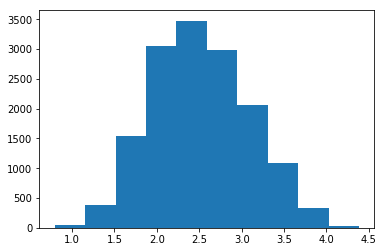

In [51]:
plt.hist(oof_train)

In [52]:
# Compute QWK based on OOF train predictions:
optR = OptimizedRounder()
optR.fit(oof_train, X_train['AdoptionSpeed'].values)
coefficients = optR.coefficients()
pred_test_y_k = optR.predict(oof_train, coefficients)
print("\nValid Counts = ", Counter(X_train['AdoptionSpeed'].values))
print("Predicted Counts = ", Counter(pred_test_y_k))
print("Coefficients = ", coefficients)
qwk = quadratic_weighted_kappa(X_train['AdoptionSpeed'].values, pred_test_y_k)
print("QWK = ", qwk)


Valid Counts =  Counter({4.0: 4197, 2.0: 4037, 3.0: 3259, 1.0: 3090, 0.0: 410})
Predicted Counts =  Counter({3.0: 3876, 1.0: 3826, 2.0: 3699, 4.0: 3592})
Coefficients =  [0.53639425 2.10876392 2.48716831 2.93809559]
QWK =  0.4613605294272327


In [53]:
# Manually adjusted coefficients:

coefficients_ = coefficients.copy()

coefficients_[0] = 1.645
coefficients_[1] = 2.115
coefficients_[3] = 2.84

train_predictions = optR.predict(oof_train, coefficients).astype(int)
print('train pred distribution: {}'.format(Counter(train_predictions)))

test_predictions = optR.predict(oof_test.mean(axis=1), coefficients)
print('test pred distribution: {}'.format(Counter(test_predictions)))

train pred distribution: Counter({3: 3876, 1: 3826, 2: 3699, 4: 3592})
test pred distribution: Counter({3.0: 1033, 1.0: 1024, 4.0: 953, 2.0: 938})


In [ ]:
# Distribution inspection of original target and predicted train and test:

print("True Distribution:")
print(pd.value_counts(X_train['AdoptionSpeed'], normalize=True).sort_index())
print("\nTrain Predicted Distribution:")
print(pd.value_counts(train_predictions, normalize=True).sort_index())
print("\nTest Predicted Distribution:")
print(pd.value_counts(test_predictions, normalize=True).sort_index())

In [ ]:
importance_type= "split" # "gain"
idx_sort = np.argsort(model.feature_importance(importance_type=importance_type))[::-1]
names_sorted = np.array(model.feature_name())[idx_sort]
imports_sorted = model.feature_importance(importance_type=importance_type)[idx_sort]
for n, im in zip(names_sorted, imports_sorted):
    print(n, im)

In [ ]:
submission = pd.DataFrame({'PetID': test['PetID'].values, 'AdoptionSpeed': test_predictions.astype(np.int32)})
submission.head()
submission.to_csv('submission.csv', index=False)